前向传播实战

到现在为止，我们已经介绍了如何创建张量、对张量进行索引切片、维度变换和常见<br>
的数学运算等操作。最后我们将利用已经学到的知识去完成三层神经网络的实现：<br>
out = 𝑅𝑒𝐿𝑈{𝑅𝑒𝐿𝑈{𝑅𝑒𝐿𝑈[𝑿@𝑾1 + 𝒃1]@𝑾2 + 𝒃2}@𝑾 + 𝒃 }<br>
ReLU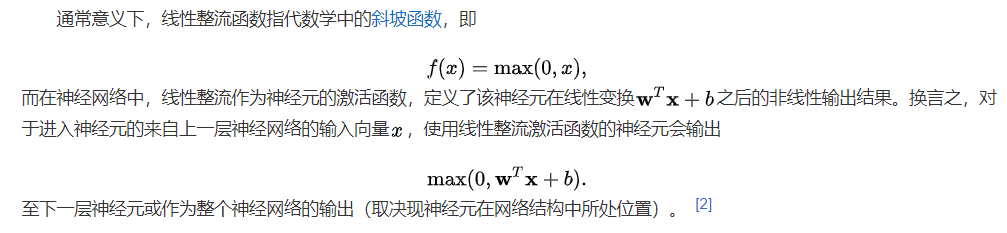
我们采用的数据集是 MNIST 手写数字图片集，输入节点数为 784，第一层的输出节点数是<br>
256，第二层的输出节点数是 128，第三层的输出节点是 10，也就是当前样本属于 10 类别<br>
的概率。<br>
首先创建每个非线性层的𝑾和𝒃张量参数，代码如下：

In [1]:
import tensorflow as tf

In [2]:
# 每层的张量都需要被优化，故使用 Variable 类型，并使用截断的正太分布初始化权值张量
# 偏置向量初始化为 0 即可
# X落在（μ-3σ，μ+3σ）以外的概率小于千分之三，在实际问题中常认为相应的事件是不会发生的，基本上可以把区间（μ-3σ，μ+3σ）看作是随机变量X实际可能的取值区间，这称之为正态分布的“3σ”原则。
# 在tf.truncated_normal中如果x的取值在区间（μ-2σ，μ+2σ）之外则重新进行选择。这样保证了生成的值都在均值附近。
# 第一层的参数
w1 = tf.Variable(tf.random.truncated_normal([784, 256], stddev=0.1))#标准差取0.1
b1 = tf.Variable(tf.zeros([256]))
# 第二层的参数
w2 = tf.Variable(tf.random.truncated_normal([256, 128], stddev=0.1))
b2 = tf.Variable(tf.zeros([128]))
# 第三层的参数
w3 = tf.Variable(tf.random.truncated_normal([128, 10], stddev=0.1))
b3 = tf.Variable(tf.zeros([10]))

In [ ]:
# 在前向计算时，首先将 shape 为[𝑏, 28,28]的输入张量的视图调整为[𝑏, 784]，即将每个图片的矩阵数据调整为向量特征，这样才适合于网络的输入格式:
# 改变视图，[b, 28, 28] => [b, 28*28]
x = tf.reshape(x, [-1, 28*28]) #x为MNIST的数据集，此处未加载
# 接下来完成第一个层的计算，我们这里显示地进行自动扩展操作:
# 第一层计算，[b, 784]@[784, 256] + [256] => [b, 256] + [256] => [b, 256] + [b, 256]
h1 = x@w1 + tf.broadcast_to(b1, [x.shape[0], 256])
h1 = tf.nn.relu(h1) # 通过激活函数
# 用同样的方法完成第二个和第三个非线性函数层的前向计算，输出层可以不使用 ReLU 激活函数：
# 第二层计算，[b, 256] => [b, 128]
h2 = h1@w2 + b2
h2 = tf.nn.relu(h2)
# 输出层计算，[b, 128] => [b, 10]
out = h2@w3 + b3
# 将真实的标注张量𝒚转变为 One-hot 编码，并计算与 out 的均方差，代码如下：
# 计算网络输出与标签之间的均方差，mse = mean(sum(y-out)^2)
# [b, 10]
loss = tf.square(y_onehot - out)
# 误差标量，mean: scalar
loss = tf.reduce_mean(loss)

上述的前向计算过程都需要包裹在 with tf.GradientTape() as tape 上下文中，使得前向计算时能够保存计算图信息，方便自动求导操作。通过 tape.gradient()函数求得网络参数到梯度信息，结果保存在 grads 列表变量中，实现如下：

In [ ]:
# 自动梯度，需要求梯度的张量有[w1, b1, w2, b2, w3, b3]
grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])

并按照
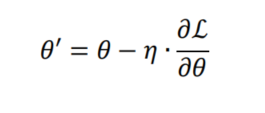
来更新网络参数

In [ ]:
# 梯度更新，assign_sub 将当前值减去参数值，原地更新
w1.assign_sub(lr * grads[0])
b1.assign_sub(lr * grads[1])
w2.assign_sub(lr * grads[2])
b2.assign_sub(lr * grads[3])
w3.assign_sub(lr * grads[4])
b3.assign_sub(lr * grads[5])

其中 assign_sub()将自身减去给定的参数值，实现参数的原地(In-place)更新操作。网络训练    
误差值的变化曲线如图所示。
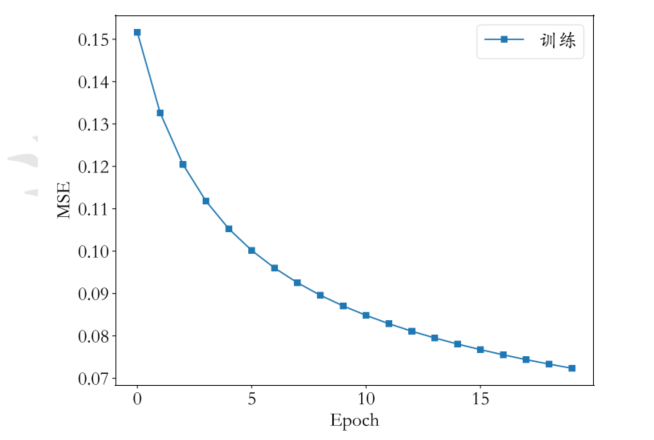